# Minimal_Monthly_Temperatures_Time_Series_Forecasting

### Shanmukha Rajasekhar Somireddi

In [4]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot

#### The dataset contains the minimum temperatures over 10 years (1981-1990) in the city Melbourne, Australia

In [5]:
train=pd.read_csv("Dataset/train_temperature_time_series.csv")
test=pd.read_csv("Dataset/test_temperature_time_series.csv")

In [6]:
train.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [7]:
test.head()

,Date,Temp
0,1990-01-01,14.8
1,1990-01-02,13.3
2,1990-01-03,15.6
3,1990-01-04,14.5
4,1990-01-05,14.3


In [8]:
train.dtypes, test.dtypes

(Date     object
 Temp    float64
 dtype: object,
 Date     object
 Temp    float64
 dtype: object)

In [9]:
train.shape, test.shape

((3285, 2), (365, 2))

In [10]:
train['Date']=pd.to_datetime(train.Date,format= '%Y-%m-%d')
test['Date']=pd.to_datetime(test.Date,format= '%Y-%m-%d')

In [11]:
for i in (train,test):
  i['year']=i.Date.dt.year
  i['month']=i.Date.dt.month
  i['day']=i.Date.dt.day

### Exploratory Data Analysis and Visualization

In [12]:
train.set_index('Date',inplace=True)

#### Plotting the data of minimal temperature over time

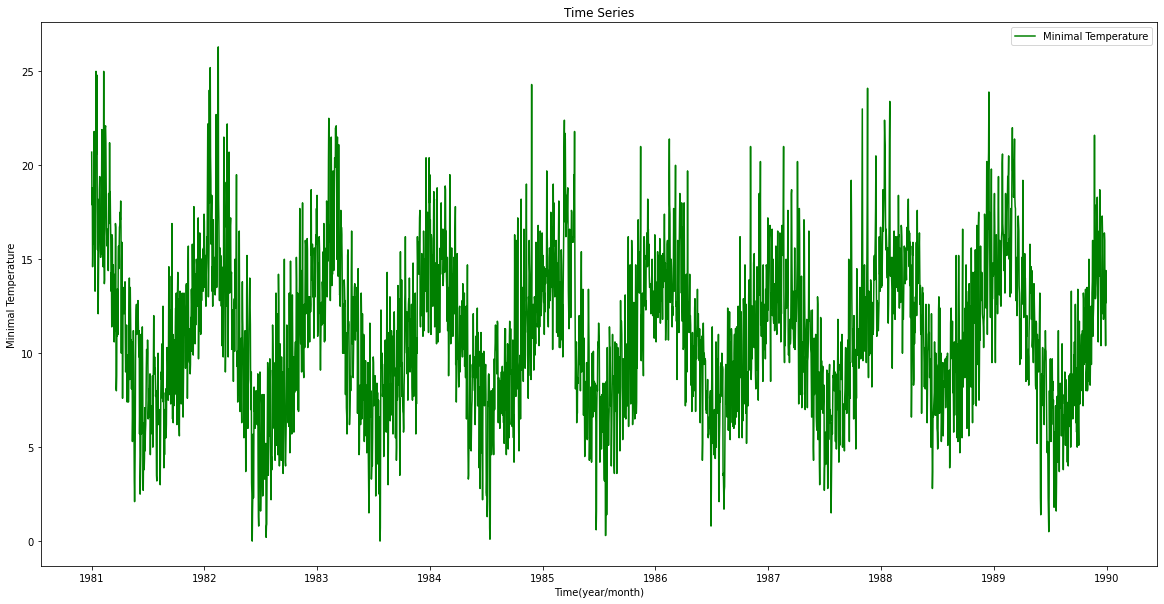

In [13]:
df=train
ts=df['Temp']
plt.figure(figsize=(20,10))
plt.plot(ts,color = 'g', label='Minimal Temperature')
plt.title('Time Series')
plt.xlabel('Time(year/month)')
plt.ylabel('Minimal Temperature')
plt.legend(loc='best')

#### Mean of minimal temperatures yearwise

<AxesSubplot:xlabel='year'>

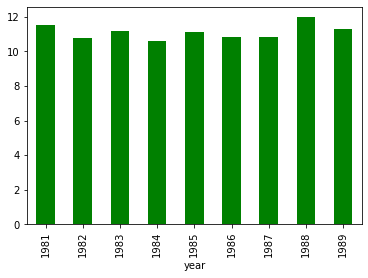

In [14]:
train.groupby('year')['Temp'].mean().plot.bar(color = 'g')

#### Mean of minimal temperatures monthwise

<AxesSubplot:xlabel='month'>

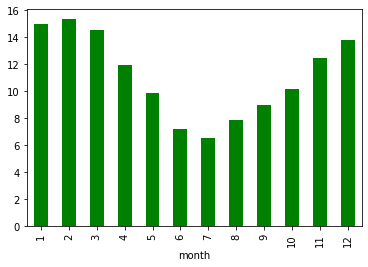

In [15]:
train.groupby('month')['Temp'].mean().plot.bar(color = 'g')

<AxesSubplot:title={'center':'Minimal Temperature (Year, Month)'}, xlabel='year,month'>

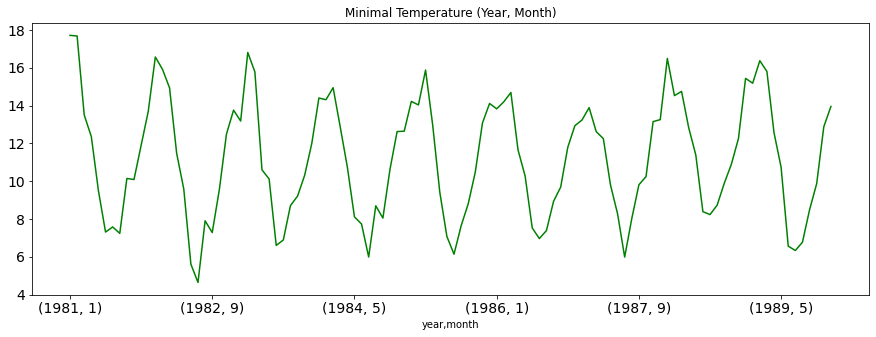

In [16]:
# Trend including month and year data
tem=train.groupby(['year', 'month'])['Temp'].mean()
tem.plot(figsize=(15,5),color = 'g', title='Minimal Temperature (Year, Month)',fontsize=14)
#Thus we understand that it is seasonal trend

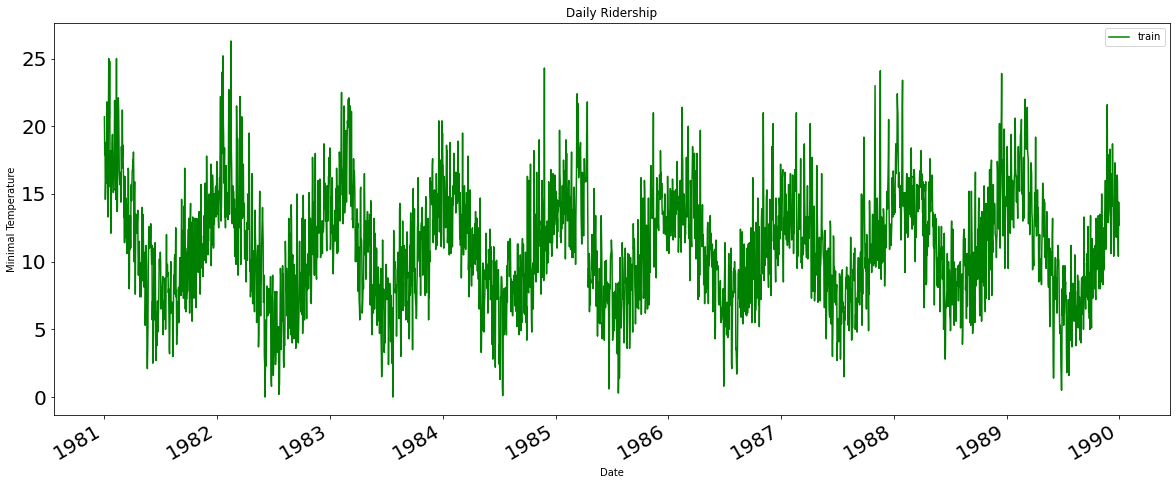

In [17]:
train.Temp.plot(figsize=(20,8),color = 'g', title='Daily Ridership',fontsize=20,label='train')
plt.xlabel('Date')
plt.ylabel('Minimal Temperature')
plt.legend(loc='best')
plt.show()

In [18]:
#To make graph smooth we will use monthly predictions
monthly_train=train.resample('M').mean()

In [19]:
monthly_train.shape

(108, 4)

In [20]:
monthly_train.head()

,Temp,year,month,day
Date,,,,
1981-01-31,17.712903,1981.0,1.0,16.0
1981-02-28,17.678571,1981.0,2.0,14.5
1981-03-31,13.500000,1981.0,3.0,16.0
1981-04-30,12.356667,1981.0,4.0,15.5
1981-05-31,9.490323,1981.0,5.0,16.0


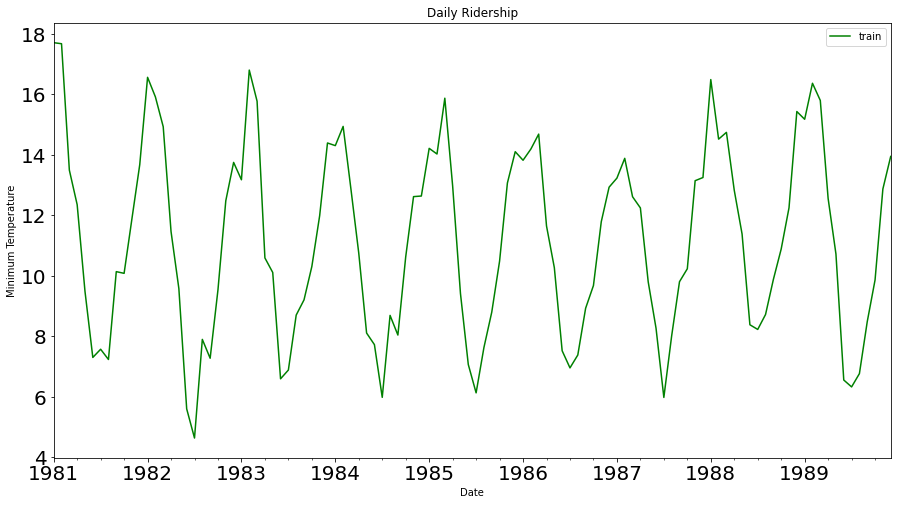

In [21]:
monthly_train.Temp.plot(figsize=(15,8),color = 'g', title='Daily Ridership',fontsize=20,label='train')
plt.xlabel('Date')
plt.ylabel('Minimum Temperature')
plt.legend(loc='best')
plt.show()

In [22]:
monthly_train.shape

(108, 4)

### Verifying Data is Stationary or not?

- Perform Dickey-Fuller test
- If p-value is less than 0.05 data is stationary

In [23]:
def test_stationarity(timeseries):
  print ('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)

test_stationarity(monthly_train['Temp'])


Results of Dickey-Fuller Test:
Test Statistic                 -1.919769
p-value                         0.322819
#Lags Used                     13.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


p-value is 0.32 therefore it is not stationary

In [24]:
#To make the Data Stationary we need to use shift command
monthly_train['Monthly Difference'] = monthly_train['Temp'] - monthly_train['Temp'].shift(12)


In [25]:
monthly_train.head(15)

,Temp,year,month,day,Monthly Difference
Date,,,,,
1981-01-31,17.712903,1981.0,1.0,16.0,NaN
1981-02-28,17.678571,1981.0,2.0,14.5,NaN
1981-03-31,13.500000,1981.0,3.0,16.0,NaN
1981-04-30,12.356667,1981.0,4.0,15.5,NaN
1981-05-31,9.490323,1981.0,5.0,16.0,NaN
1981-06-30,7.306667,1981.0,6.0,15.5,NaN
1981-07-31,7.577419,1981.0,7.0,16.0,NaN
1981-08-31,7.238710,1981.0,8.0,16.0,NaN
1981-09-30,10.143333,1981.0,9.0,15.5,NaN


### Rerun the dicky-fuller test after making the data stationary

In [26]:
test_stationarity(monthly_train['Monthly Difference'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                 -3.972509
p-value                         0.001562
#Lags Used                     11.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


<AxesSubplot:xlabel='Date'>

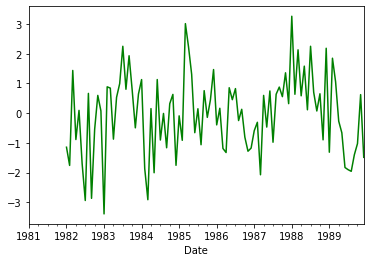

In [27]:
monthly_train['Monthly Difference'].plot(color='g')

In [28]:
monthly_train.shape

(108, 5)

#### Autocorrelation and Partial Autocorrelatio Plots

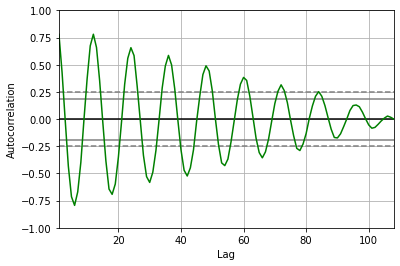

In [40]:
autocorrelation_plot(monthly_train['Temp'], color='green')
plt.show()

/Users/kishore/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


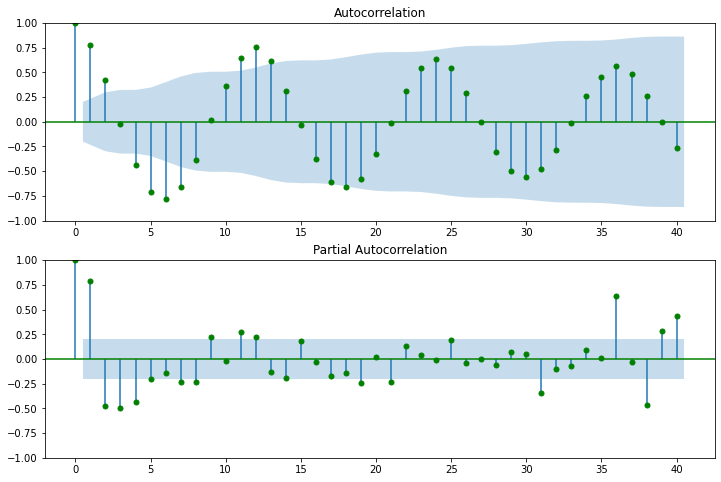

In [41]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly_train['Temp'].iloc[13:],lags=40,ax=ax1, color='green')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly_train['Temp'].iloc[13:],lags=40,ax=ax2, color='green')

- p AR lags look pacf
- d differencing
- q MA lags look acf

#### Seasonal Autoregressive Integrated Moving Average (SARIMA)

In [31]:
model = sm.tsa.statespace.SARIMAX(monthly_train['Temp'], order=(1,1,2), seasonal_order=(1,1,2,12))
results=model.fit()

/Users/kishore/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48022D+00    |proj g|=  2.43246D-01

At iterate    5    f=  1.34901D+00    |proj g|=  8.56843D-03

At iterate   10    f=  1.34711D+00    |proj g|=  9.10674D-04

At iterate   15    f=  1.34671D+00    |proj g|=  1.06133D-03

At iterate   20    f=  1.34666D+00    |proj g|=  5.02306D-04

At iterate   25    f=  1.34662D+00    |proj g|=  2.22603D-04

At iterate   30    f=  1.34662D+00    |proj g|=  2.03997D-04

At iterate   35    f=  1.34662D+00    |proj g|=  1.29600D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<AxesSubplot:xlabel='Date'>

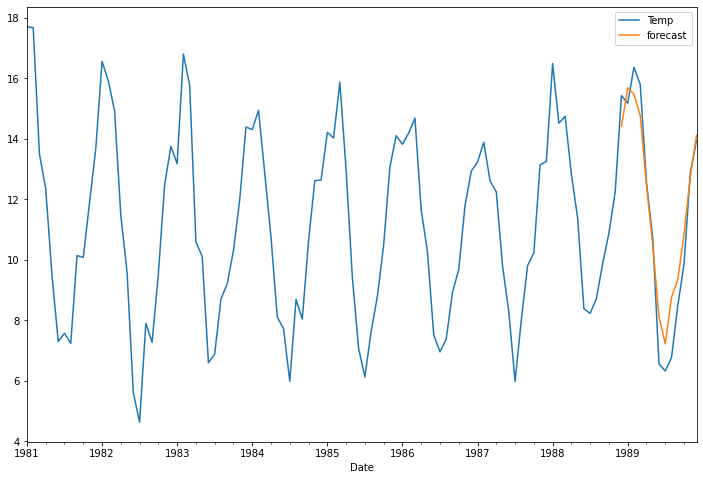

In [43]:
monthly_train['forecast']=results.predict(start=95, end=108, dynamic=True)
monthly_train[['Temp', 'forecast']].plot(figsize=(12, 8))

#### Test on the next year minimal Temperature

In [34]:
test.set_index('Date', inplace=True)

In [36]:
monthly_test = test.resample('M').mean()

In [37]:
future_temp = pd.concat([monthly_train, monthly_test])

/Users/kishore/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


<AxesSubplot:xlabel='Date'>

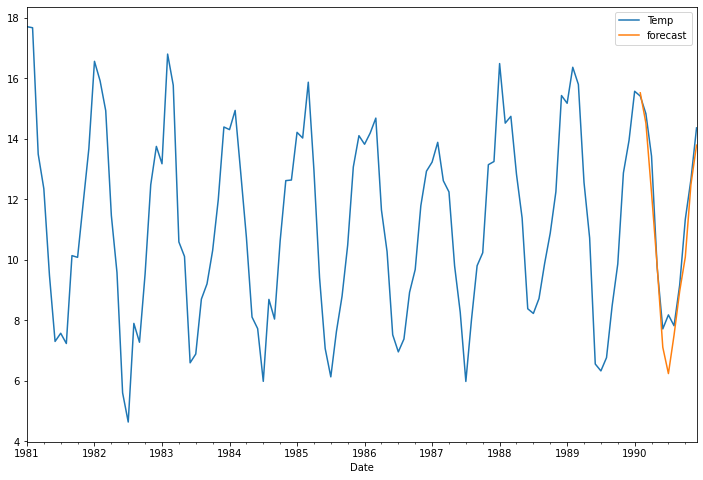

In [45]:
future_temp['forecast'] = results.predict(start=109, end=120, dynamic=True)
future_temp[['Temp', 'forecast']].plot(figsize = (12, 8))